In [1]:
import pandas as pd
import numpy as np
import os
from os.path import join

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

from tqdm.notebook import tqdm

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold

In [3]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords

In [4]:
import youtokentome as yttm

In [5]:
data_1 = pd.read_csv('data/SPAM text message 20170820 - Data.csv', index_col='Category').rename(columns={'Message':'text'},)
data_2 = pd.read_csv('data/spam.csv', index_col='v1')[['v2']].rename(columns={'v2':'text'})
data_3 = pd.read_csv('data/spam_ham_dataset.csv', index_col='label')[['text']]

посмоторим на соотношение классов данных

In [28]:
data_1.groupby('Category').count()

,text
Category,
ham,4825
spam,747


In [29]:
data_2.groupby('v1').count()

,text
v1,
ham,4825
spam,747


In [30]:
data_3.groupby('label').count()

,text
label,
ham,3672
spam,1499


In [31]:
# первые два датасета __очень__ сильно пересекаются. Будем считать что это один и тот же датасет.
# Все три датасета можно объединить только если они стилистически похожи. посмотрим
print(data_1.text.iloc[10])
print('_________')
print(data_3.text.iloc[5])

I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
_________
ehronline web address change this message is intended for ehronline users only . due to a recent change to ehronline , the url ( aka " web address " ) for accessing ehronline needs to be changed on your computer . the change involves adding the letter " s " to the " http " reference in the url . the url for accessing ehronline should be : https : / / ehronline . enron . com . this change should be made by those who have added the url as a favorite on the browser .


Первое что бросается в глаза -- в последнем датасете более длинные сообщения и везде присуствует заголовок. Обе этих проблемы можно обыграть по-разному, но главное убрать слово subject. Иначе модель может подумать, что это хороший признак для спама (2/3 всего спама будет начинаться с него, против менее чем половины хама).

In [6]:
data_3.text = data_3.text.apply(lambda x: x.replace('Subject: ', '').replace('\n', ' ').replace('\r', ''))

In [7]:
data = pd.concat([data_1, data_2, data_3]).drop_duplicates()
data.index = pd.Index(map(lambda x: int(x == 'spam'), data.index))
data

,text
0,"Go until jurong point, crazy.. Available only ..."
0,Ok lar... Joking wif u oni...
1,Free entry in 2 a wkly comp to win FA Cup fina...
0,U dun say so early hor... U c already then say...
0,"Nah I don't think he goes to usf, he lives aro..."
...,...
1,slutty milf wants to meet you take that ! ' il...
0,put the 10 on the ft the transport volumes dec...
0,3 / 4 / 2000 and following noms hpl can ' t ta...
0,industrial worksheets for august 2000 activity...


In [19]:
def train_val(clf, X_train, X_test, y_train, y_test, vectorizer, full=False):

    train_vec = vectorizer.fit_transform(X_train) 
    test_vec  = vectorizer.transform(X_test)
    
    clf.fit(train_vec, y_train)
    pred = clf.predict(test_vec)

    if full:
        plot_confusion_matrix(clf, test_vec, y_test)

        print(classification_report(y_test, pred))
    
    return matthews_corrcoef(y_test, pred)

In [20]:
def bpe_trasform(X_train, X_test):
    # в реализации bpe от youtokentome вот такой странный интерфейс
    # сохраняем данные на диск
    with open('X_train', 'w') as f:
        for el in X_train:
            f.write(el+'\n')  
    
    # обучаем токенизатор
    yttm.BPE.train(data='X_train', vocab_size=5000, model='tmp')
    
    # загружаем обученную модель
    bpe = yttm.BPE(model='tmp')
    
    # получаем представления предложений
    X_train_enc = bpe.encode(X_train.tolist())
    X_tes_enc = bpe.encode(X_test.tolist())
    
    # превращаем представления обратно в "читаемый" вид 
    #(в кавычках, потому что теперь вместо привычных слов наборы токенов)
    X_train_tokened = []
    for text in X_train_enc:
        X_train_tokened.append(' '.join(bpe.id_to_subword(el) for el in text))
        
    X_test_tokened = []
    for text in X_tes_enc:
        X_test_tokened.append(' '.join(bpe.id_to_subword(el) for el in text))
        
    return X_train_tokened, X_test_tokened

In [21]:
def cross_val(clf, data, vectorizer, full=False):
    res = []
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    y = data.index
    for train_indxs, test_indxs in tqdm(kf.split(data, y), total=5):
        train_data, test_data = data.text.iloc[train_indxs],  data.text.iloc[test_indxs]
        
        X_train, y_train = train_data.values, train_data.index
        X_test, y_test = test_data.values, test_data.index
        
        # добавилась эта строка. 
        # Превратим предложения из набора слов в набор токенов -- tfidf заиграет более интересными красками
        X_train_tokened, X_test_tokened = bpe_trasform(X_train, X_test)
    
        res.append(train_val(clf, X_train_tokened, X_test_tokened, y_train, y_test, vectorizer))
    return res

In [22]:
nltk.download('wordnet')
stop_words = stopwords.words("english")

[nltk_data] Downloading package wordnet to /home/stas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
data.text = data.text.apply(lambda x:' '.join([word.lower() for word in x.split(' ') if word.lower not in stop_words]))


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    data.text, data.index, test_size = 0.2,stratify=data.index)

In [25]:
X_train_tokened, X_test_tokened = bpe_trasform(X_train, X_test)

In [26]:
vectorizer = TfidfVectorizer(  
    lowercase=True,      
    stop_words='english' 
)

In [27]:
classifier = MultinomialNB()
res = cross_val(classifier, data, vectorizer)
print(np.round(res,4), np.round(sum(res)/len(res), 4))
train_val(classifier, X_train_tokened, X_test_tokened, y_train, y_test, vectorizer, full=True)

[0 1 0 ... 0 0 0]
[0 1 1 ... 1 0 1]



KeyboardInterrupt: 


[0.8706 0.8906 0.9032 0.9046 0.892 ] 0.8922
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1685
           1       0.98      0.88      0.92       470

    accuracy                           0.97      2155
   macro avg       0.97      0.94      0.95      2155
weighted avg       0.97      0.97      0.97      2155



0.9060297939731272

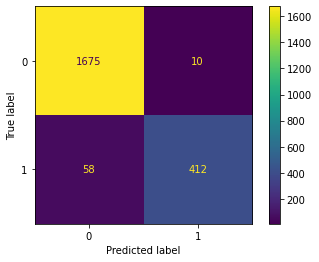

In [17]:
classifier = RandomForestClassifier()
res = cross_val(classifier, data, vectorizer)
print(np.round(res,4), np.round(sum(res)/len(res), 4))
train_val(classifier, X_train_tokened, X_test_tokened, y_train, y_test, vectorizer, full=True)


[0.9131 0.9103 0.9146 0.9228 0.9074] 0.9136
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1685
           1       0.98      0.90      0.94       470

    accuracy                           0.98      2155
   macro avg       0.98      0.95      0.96      2155
weighted avg       0.98      0.98      0.98      2155



0.9270540744193574

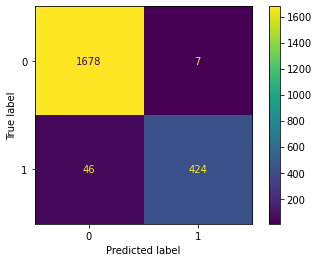

In [18]:
classifier = SVC()
res = cross_val(classifier, data, vectorizer)
print(np.round(res,4), np.round(sum(res)/len(res), 4))
train_val(classifier, X_train_tokened, X_test_tokened, y_train, y_test, vectorizer, full=True)

Преобразование исходный предложений (набор слов) в набор токенов дал прирост по метрикам, однако у моделей все еще наблюдаются проблемы с выучиванием редкого класса спама.